In [1]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
im_path = r'BONBID2023_Train\BONBID2023_Train\1ADC_ss'
adc2 = r'BONBID2023_Train\BONBID2023_Train\2Z_ADC'
label_path = r'BONBID2023_Train\BONBID2023_Train\3LABEL'

val_ = r'BONBID2023_Train\BONBID2023_Train\1ADC_ss'
val_2 = r'BONBID2023_Train\BONBID2023_Train\2Z_ADC'
val_label = r'BONBID2023_Train\BONBID2023_Train\3LABEL'

# im_path and adc2 are images. Label_path are masks

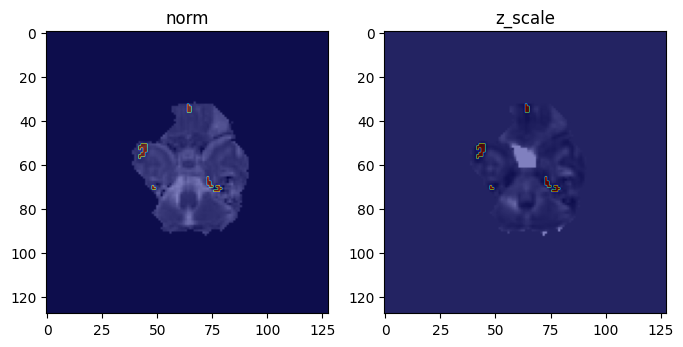

In [3]:
path = im_path
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(path, os.listdir(path)[0])))[2], cmap = 'gray')
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(label_path, os.listdir(label_path)[0])))[2], cmap='jet',alpha=0.5)
plt.title('norm')

plt.subplot(122)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(adc2, os.listdir(adc2)[0])))[2], cmap = 'gray')
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(label_path, os.listdir(label_path)[0])))[2], cmap='jet',alpha=0.5)
plt.title('z_scale')

plt.show()

# We can see left one is more detailed while right is less noisey. Right looks lower resolution, though same image size.

In [4]:
size = dict()
for name in os.listdir(path):
    temp_tup = sitk.ReadImage(os.path.join(path, name)).GetSize()
    size[temp_tup] = size.get(temp_tup, 0) + 1

In [5]:
print(size)
# Varying input shapes

{(128, 128, 23): 5, (256, 256, 19): 1, (256, 256, 46): 3, (256, 256, 45): 4, (256, 256, 48): 3, (256, 256, 42): 1, (256, 256, 40): 2, (256, 256, 43): 1, (256, 256, 49): 2, (128, 128, 64): 3, (256, 256, 56): 1, (256, 256, 28): 1, (256, 256, 25): 3, (256, 256, 27): 1, (128, 128, 54): 3, (128, 128, 52): 6, (256, 256, 60): 1, (128, 128, 50): 9, (128, 128, 60): 2, (160, 160, 18): 3, (128, 128, 57): 1, (128, 128, 59): 1, (128, 128, 55): 1, (128, 128, 56): 1, (128, 128, 34): 1, (128, 128, 53): 1, (160, 160, 17): 4, (256, 256, 24): 1, (160, 160, 16): 3, (160, 160, 24): 1, (160, 160, 21): 1, (256, 256, 23): 1, (160, 160, 28): 3, (160, 160, 19): 2, (160, 160, 20): 6, (160, 160, 25): 1, (160, 160, 22): 1}


In [6]:
sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(im_path, os.listdir(im_path)[0]))).shape

# Working with 3d images

(23, 128, 128)

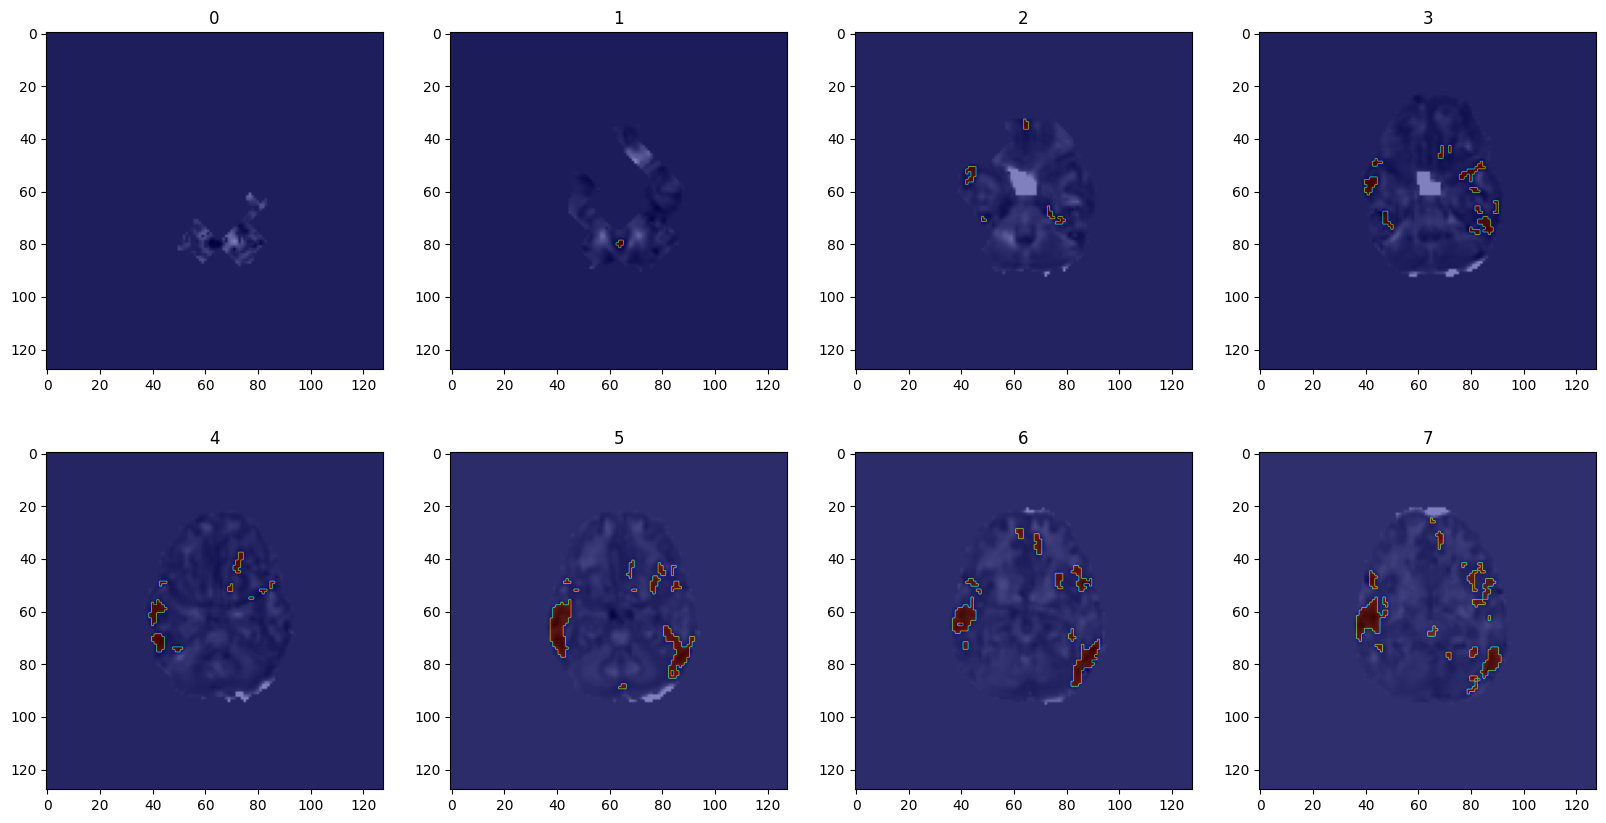

In [7]:
fig,axs=plt.subplots(2,4,figsize=(20,10))
ax=axs.ravel()
temp_im=sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(adc2,os.listdir(adc2)[0])))
temp_lbl=sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(label_path,os.listdir(label_path)[0])))
for idx,i in enumerate(ax):
    i.imshow(temp_im[idx],cmap='gray')
    i.imshow(temp_lbl[idx],cmap='jet',alpha=0.5)
    i.set_title(idx)
plt.show()

# Lot's of wasted space. Ok, can get pad for const input, but this space is excessive, unnecessary training time + more negative classes. Can probably trim it.

21 99 36 96


[]

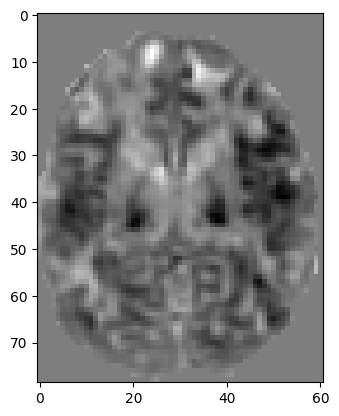

In [8]:
#21-99y
#36-96y
temp_look=np.argwhere(temp_im>0).T
print(temp_look[1].min(),temp_look[1].max(),temp_look[2].min(),temp_look[2].max())
#1 axis = y, 2 = x - min, max

plt.figure()
plt.imshow(temp_im[10,21:100,36:97],cmap='gray')
plt.plot()

#Diff of this one im is 77(height), 60(width). Let's see all train max to see "good" split size

In [9]:
xdiff,ydiff=0,0
for file in os.listdir(im_path):
    temp=np.argwhere(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(im_path, file)))>0).T
    xdiff=max(temp[1].max()-temp[1].min(),xdiff)
    ydiff=max(temp[2].max()-temp[2].min(),ydiff)
print(xdiff,ydiff)
#Max trimming i can do is to 194x153.likely due to 256x256 ims.Clearly a weird size. maybe just resize to larger scale/ pad. But need to see if they match for best choice. 

194 153


In [10]:
for i in os.listdir(im_path):
    temp12=sitk.ReadImage(os.path.join(im_path, i))
    if temp12.GetSize()[1]==256:
        temp12=sitk.GetArrayFromImage(temp12)
        break

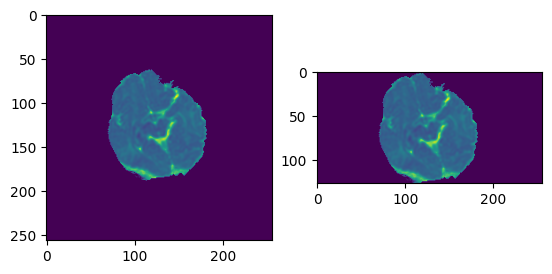

In [11]:
#61,188
plt.subplot(121)
plt.imshow(temp12[8])
plt.subplot(122)
plt.imshow(temp12[8,61:188])
plt.show()

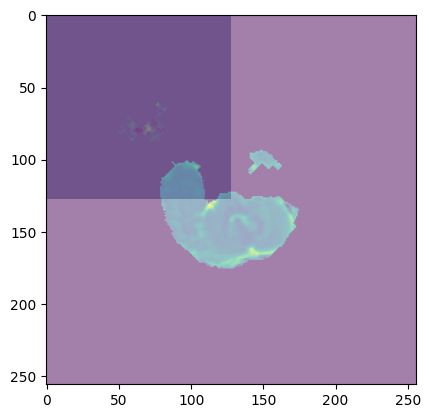

In [12]:
plt.figure()
plt.imshow(temp_im[0],alpha=0.5)
plt.imshow(temp12[5],alpha=0.5)
plt.show()

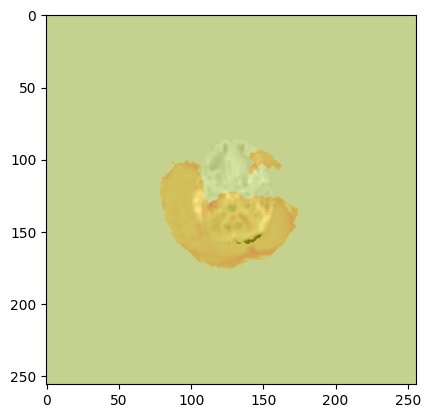

In [13]:
temp20=np.pad(temp_im[5],64)

plt.figure()
plt.imshow(temp12[5],alpha=1,cmap='Wistia')
plt.imshow(temp20,alpha=0.5,cmap='binary')
plt.show()

# Padding is no good.

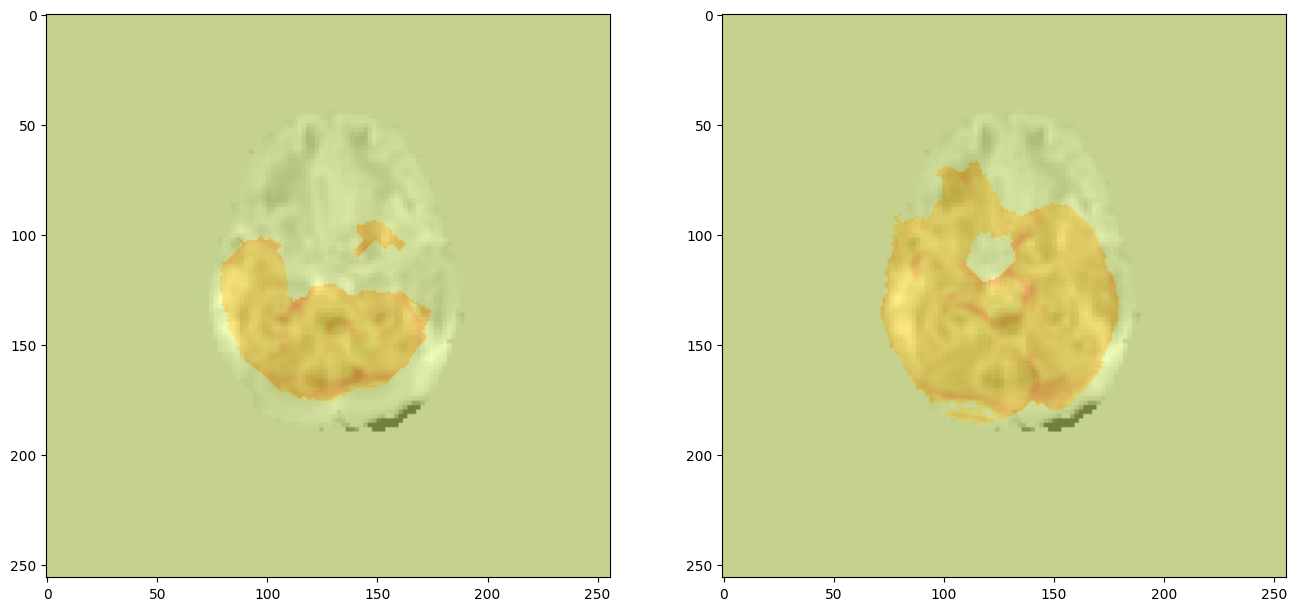

In [14]:
temp21=temp_im[5].repeat(2, axis=0).repeat(2, axis=1)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(temp12[5],alpha=1,cmap='Wistia')
plt.imshow(temp21,alpha=0.5,cmap='binary')

plt.subplot(122)
plt.imshow(temp12[7],alpha=1,cmap='Wistia')
plt.imshow(temp21,alpha=0.5,cmap='binary')
plt.show()

# Resizing looks far better than padding. Padding will confuse conv filters, i.e., convolutions will learn position of same targets/areas at different kernels in max_pooling with paddding. Location to scale with resizing 

In [15]:
print(temp_im.mean())
# Strange, z scale image should be mean = 0.
print(temp_im.max(), temp_im.min())
# The max being 10 could mean there's clipping done to 10. Hence why mean is negative also. Probably not a big deal - limit outliers

-0.100631334
10.0 -8.467915


In [16]:
temp12.max()
# Raw image. mri scan, so extreme values normal.

4095.0

# Model Stuff

Metrics:
- Precision
- Recall
- Accuracy
- Dice

Things to test:
- 2D Covnet
- 3D covnet
- Trimmed inputs (negative space) vs non trimmed.

3D - (batch, depth, height, width, channels)
2D - (batch, height, width, channels)

In [17]:
# im_path = r'BONBID2023_Train\BONBID2023_Train\1ADC_ss'
train_path = r'BONBID2023_Train\BONBID2023_Train\2Z_ADC'
train_label = r'BONBID2023_Train\BONBID2023_Train\3LABEL'

# val_ = r'BONBID2023_Train\BONBID2023_Train\1ADC_ss'
test_path = r'BONBID2023_Val\2Z_ADC'
test_label = r'BONBID2023_Val\3LABEL'

# No validation set. Actual test set is password protected, so cannot obtain true test set. Use validation set as test.

In [149]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, train_path, train_label, batch, **kwargs):
        super().__init__(**kwargs)
        temp = os.listdir(train_path)
        self.x = [self._preprocess(train_path, i) for i in temp]
        if train_label is not None:
            self.y = [self._preprocess(train_label, i, True) for i in [(i.split('-')[0]+'-VISIT_01_'+'lesion.mha').split('Zmap_')[1] for i in temp]]
            self.y=tf.concat(self.y,axis=0)
        self.x=tf.concat(self.x,axis=0)
        self.batch = batch
    
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch))
    
    def __getitem__(self, indices):
        items = self.x[indices*self.batch:(indices + 1)*self.batch]
        if train_label is not None:
            y_items=self.y[indices*self.batch:(indices + 1)*self.batch]
            return items,y_items
        return items,

    def on_epoch_end(self):
        temp=np.arange(len(self.x))
        np.random.shuffle(temp)
        self.x=[self.x[i] for i in temp]
        self.y=[self.y[i] for i in temp]

    def tester(self):
        return self.x, self.y

    def _preprocess(self, path, name, cond=False):
        im = tf.convert_to_tensor(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(path, name))))
        im = tf.transpose(im, [1, 2, 0])
        im = tf.image.resize(im, (256, 256))
        im = tf.transpose(im, [2, 0, 1])
        #Keep label resize binary
        if cond is True:
            im = tf.where(im>0,1,0)
        im=tf.expand_dims(im,-1)
        return im

In [19]:
train_data=DataGen(train_path, train_label, 16)

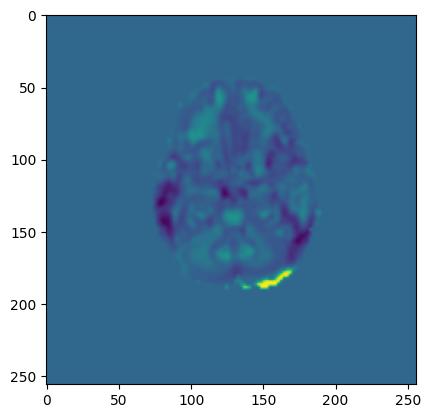

In [20]:
plt.imshow(train_data.tester()[0][5].numpy())
# Looks fine and good scale.

In [114]:
def covnet2d(input_shape):
    input_layer = tf.keras.layers.Input((input_shape,input_shape,1))
    x1=tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_layer)
    x=tf.keras.layers.MaxPooling2D(padding='same')(x1)
    x2=tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.MaxPooling2D(padding='same')(x2)
    x3=tf.keras.layers.Conv2D(48,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.UpSampling2D()(x3)
    x=tf.keras.layers.concatenate([x2,x])
    x=tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.UpSampling2D()(x)
    x=tf.keras.layers.concatenate([x1,x])
    x=tf.keras.layers.Conv2D(48,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)
    return tf.keras.Model(input_layer,x)
# cov2d_=covnet2d(256)
# Mini model (memory + gpu constraint)

In [ ]:
# cov2d_.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer='Adam')
# cov2d_.fit(train_data,epochs=1)

In [150]:
cov2d = tf.keras.models.load_model('unet2d.keras')

In [151]:
test_data=DataGen(test_path, test_label, 32)

In [152]:
unet2d_preds = cov2d.predict(tf.stack(test_data.tester()[0]))

3/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:5 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CCCDE29F30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [153]:
print(np.where(unet2d_preds>0.5,1,0).sum(), (test_data.tester()[1].numpy()==1).sum())
# Doesn't look too bad so far. In terms of dist

unet_preds = np.where(unet2d_preds>0.5,1,0).flatten()
unet_true = test_data.tester()[1].numpy().flatten()

96856 113393


In [154]:
def accuracy(y_true, y_pred):
    print((y_true == y_pred).sum() / len(y_true))

def precision(y_true, y_pred):
    pos = np.sum((y_true == 1) & (y_pred == 1))
    print(pos / ((y_pred == 1).sum()))

def recall(y_true, y_pred):
    pos = np.sum((y_true == 1) & (y_pred == 1))
    print(pos / ((y_true == 1).sum()))

def dice(y_true, y_pred):
    intersection = np.sum((y_true == 1) & (y_pred == 1))
    dice = (2 * intersection) / (np.sum(y_true) + np.sum(y_pred))
    print(dice)

accuracy(unet_true,unet_preds)
precision(unet_true,unet_preds)
recall(unet_true,unet_preds)
dice(unet_true,unet_preds)

# Can see weakness certainly in recall metric, i.e., lacking prediction on TP. Quite conservative, even though it's accurate.

0.9970105489095052
0.9761398364582473
0.8337816267318089
0.8993621848379778


In [61]:
sitk.ReadImage(os.path.join(test_path, os.listdir(test_path)[1])).GetSize()

(128, 128, 21)

In [74]:
single_pred = np.where(np.transpose(unet2d_preds.squeeze()[:21],[1,2,0])>0.5,1,0)
single_true=np.transpose(test_data.tester()[1].numpy()[:21].squeeze(),[1,2,0])
single_im=np.transpose(test_data.tester()[0].numpy()[:21].squeeze(),[1,2,0])

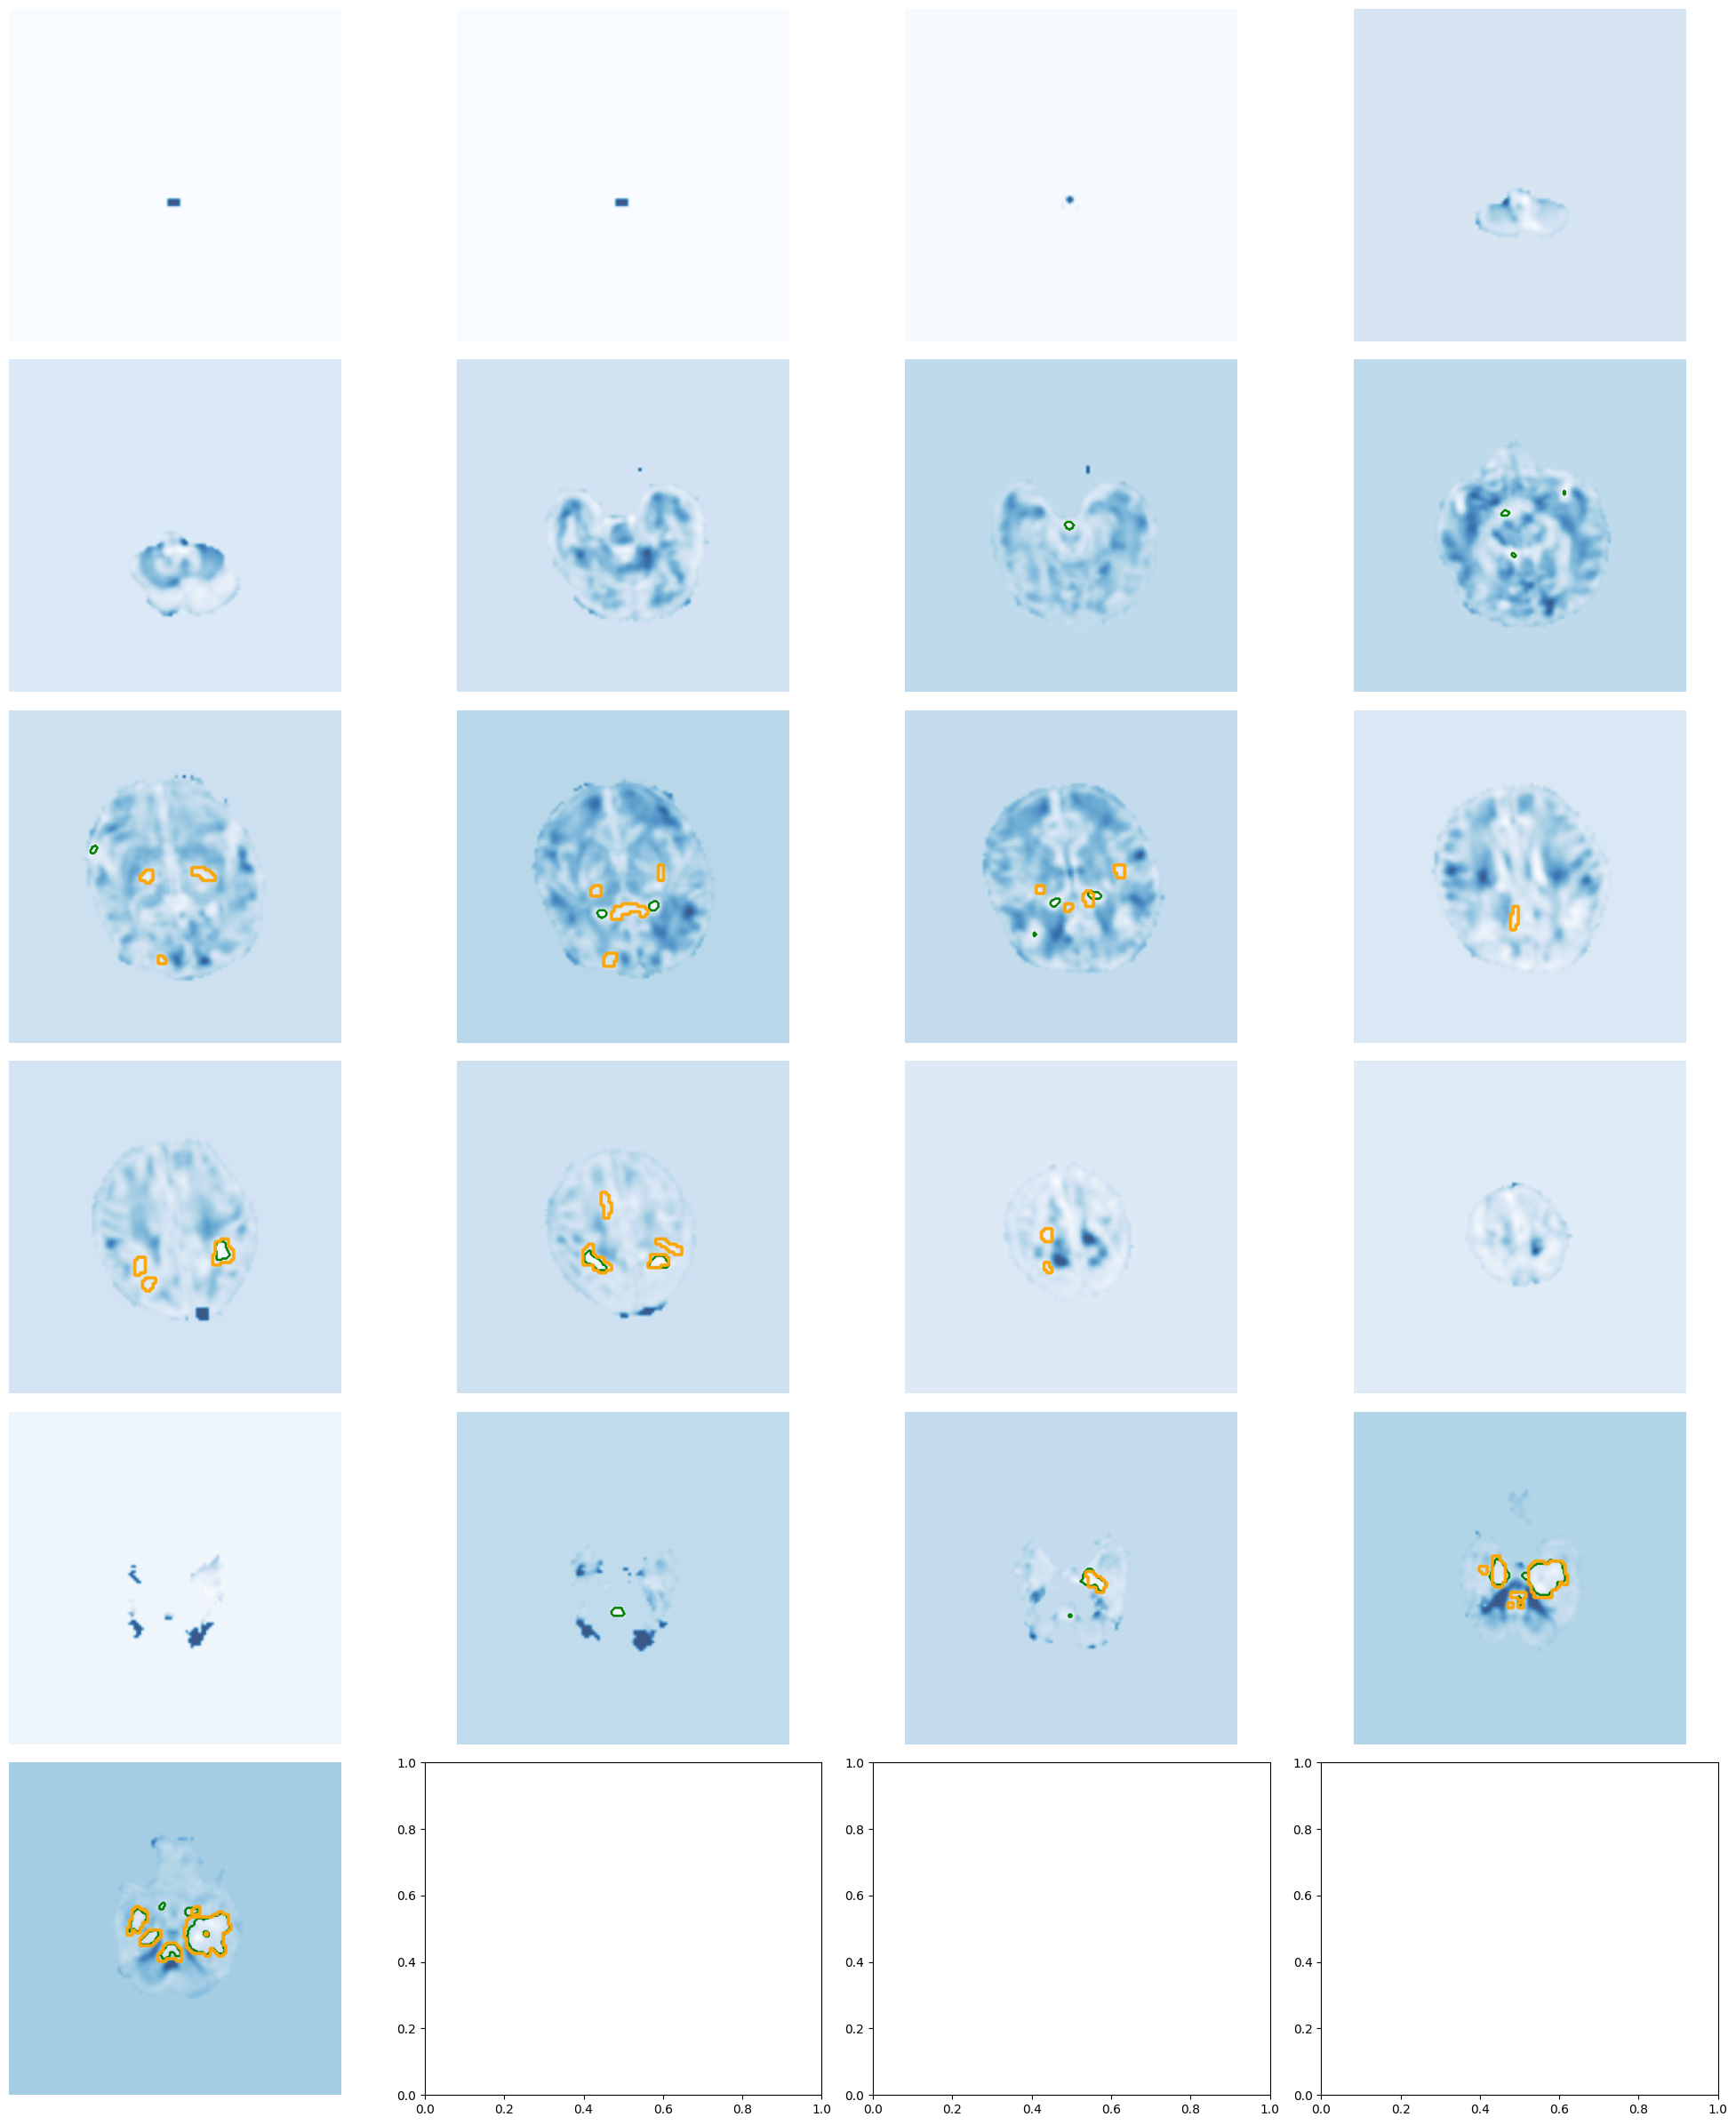

In [ ]:
fig,axes=plt.subplots(6,4,figsize=(20,24))
ax=axes.ravel()[:21]
for idx,axs in enumerate(ax):
    axs.imshow(single_im[:,:,idx],cmap='Blues',alpha=0.8)
    axs.contour(single_pred[:, :, idx],colors='green',linewidths=1,alpha=0.6)
    axs.contour(single_true[:, :, idx],colors='orange',linewidths=2,alpha=0.4)
    axs.axis('off')
plt.tight_layout()
plt.show()
# Green = predictions, orange = True. Can certainly see some issues, but overall quite good.

# Reduced input dim.

In [192]:
# Redo datagen for ease

class DataGen(tf.keras.utils.Sequence):
    def __init__(self, train_path, train_label, batch, **kwargs):
        super().__init__(**kwargs)
        temp = os.listdir(train_path)
        self.x = [self._preprocess(train_path, i) for i in temp]
        if train_label is not None:
            self.y = [self._preprocess(train_label, i, True) for i in [(i.split('-')[0]+'-VISIT_01_'+'lesion.mha').split('Zmap_')[1] for i in temp]]
            self.y=tf.concat(self.y,axis=0)
        self.x=tf.concat(self.x,axis=0)
        self.batch = batch
    
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch))
    
    def __getitem__(self, indices):
        items = self.x[indices*self.batch:(indices + 1)*self.batch]
        if train_label is not None:
            y_items=self.y[indices*self.batch:(indices + 1)*self.batch]
            return items,y_items
        return items,

    def on_epoch_end(self):
        temp=np.arange(len(self.x))
        np.random.shuffle(temp)
        self.x=[self.x[i] for i in temp]
        self.y=[self.y[i] for i in temp]

    def tester(self):
        return self.x, self.y

    def _preprocess(self, path, name, cond=False, minimize=True):
        im = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(path, name)))
        try:
            tempmin=np.argwhere(im>0).min(axis=0)
            tempmax=np.argwhere(im>0).max(axis=0)
        except ValueError:
            tempmin=[0,0,0]
            x = int(np.shape(im)[1])
            if x> 200:
                tempmax=[0,200,200]
            else:
                tempmax=[0,x,x]
        im=tf.convert_to_tensor(im)
        # Added to make smaller
        if minimize is True:
            im = tf.transpose(im, [1, 2, 0])
            im=im[tempmin[1]:tempmax[1],tempmin[2]:tempmax[2],:]
            # y_pad = max(0, 200 - (tempmax[1] - tempmin[1]))
            # x_pad = max(0, 200 - (tempmax[2] - tempmin[2]))
            # im=tf.pad(im, [[y_pad//2,y_pad-y_pad//2],[x_pad//2,x_pad-x_pad//2],[0,0]])
            im = tf.image.resize(im, (200,200))
            im = tf.transpose(im, [2, 0, 1])
            
        else:
            im = tf.transpose(im, [1, 2, 0])
            im = tf.image.resize(im, (256, 256))
            im = tf.transpose(im, [2, 0, 1])
        #Keep label resize binary
        if cond is True:
            im = tf.where(im>0,1,0)
        im=tf.expand_dims(im,-1)
        return im

In [193]:
test_=DataGen(test_path, test_label, 32)

In [163]:
def covnet2d():
    input_layer = tf.keras.layers.Input((200,200,1))
    x1=tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_layer)
    x=tf.keras.layers.MaxPooling2D(padding='same')(x1)
    x2=tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.MaxPooling2D(padding='same')(x2)
    x3=tf.keras.layers.Conv2D(48,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.UpSampling2D()(x3)
    x=tf.keras.layers.concatenate([x2,x])
    x=tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.UpSampling2D()(x)
    x=tf.keras.layers.concatenate([x1,x])
    x=tf.keras.layers.Conv2D(48,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)
    return tf.keras.Model(input_layer,x)
# cov2d_=covnet2d()

In [137]:
# save_model = tf.keras.callbacks.ModelCheckpoint('unet2d_minimized.keras')
# cov2d_.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer='Adam')
# cov2d_.fit(train_data,epochs=10,callbacks=[save_model])

In [164]:
cov2d_min = tf.keras.models.load_model('unet2d_minimized.keras')

In [165]:
test_data=DataGen(test_path, test_label, 32)

In [166]:
unet2d_preds = cov2d.predict(tf.stack(test_data.tester()[0]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [ ]:
print(np.where(unet2d_preds>0.5,1,0).sum(), (test_data.tester()[1].numpy()==1).sum())

unet_preds = np.where(unet2d_preds>0.5,1,0).flatten()
unet_true = test_data.tester()[1].numpy().flatten()
accuracy(unet_true,unet_preds)
precision(unet_true,unet_preds)
recall(unet_true,unet_preds)
dice(unet_true,unet_preds)

# Performance now worse. Most likely due to resizing = more 1 class. Or by how I'm treating the resizing, i.e., > 0 = 1.

22599 23821
0.9978666666666667
0.8231337669808398
0.7809076025355779
0.8014648858250754


# 3D UNET

In [204]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, train_path, train_label, batch, **kwargs):
        super().__init__(**kwargs)
        temp = os.listdir(train_path)
        self.x = [self._preprocess(train_path, i) for i in temp]
        if train_label is not None:
            self.y = [self._preprocess(train_label, i, True) for i in [(i.split('-')[0]+'-VISIT_01_'+'lesion.mha').split('Zmap_')[1] for i in temp]]
            self.y=tf.concat(self.y,axis=0)
        self.x=tf.concat(self.x,axis=0)
        self.batch = batch
    
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch))
    
    def __getitem__(self, indices):
        items = self.x[indices*self.batch:(indices + 1)*self.batch]
        if train_label is not None:
            y_items=self.y[indices*self.batch:(indices + 1)*self.batch]
            return items,y_items
        return items,

    def on_epoch_end(self):
        temp=np.arange(len(self.x))
        np.random.shuffle(temp)
        self.x=[self.x[i] for i in temp]
        self.y=[self.y[i] for i in temp]

    def tester(self):
        return self.x, self.y

    def _preprocess(self, path, name, cond=False):
        im = tf.convert_to_tensor(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(path, name))))
        im = tf.transpose(im, [1, 2, 0])
        im = tf.image.resize(im, (256, 256))
        im = tf.transpose(im, [2, 0, 1])
        #Keep label resize binary
        if cond is True:
            im = tf.where(im>0,1,0)
        im=tf.expand_dims(im,-1)
        im=tf.expand_dims(im,1)
        return im

In [216]:
def covnet2d():
    input_layer = tf.keras.layers.Input((1,256,256,1))
    x1=tf.keras.layers.Conv3D(16,3,padding='same',activation='relu')(input_layer)
    x=tf.keras.layers.MaxPooling3D(padding='same')(x1)
    x2=tf.keras.layers.Conv3D(32,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.MaxPooling3D(padding='same')(x2)
    x3=tf.keras.layers.Conv3D(48,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.UpSampling3D((1,2,2))(x3)
    x=tf.keras.layers.concatenate([x2,x])
    x=tf.keras.layers.Conv3D(64,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.UpSampling3D((1,2,2))(x)
    x=tf.keras.layers.concatenate([x1,x])
    x=tf.keras.layers.Conv3D(48,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv3D(32,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv3D(1,3,padding='same',activation='sigmoid')(x)
    return tf.keras.Model(input_layer,x)
cov2d_=covnet2d()

In [218]:
# test_=DataGen(test_path, test_label, 32)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_31 (Conv3D)  │ (None, 1, 256,    │        448 │ input_layer_11[0… │
│                     │ 256, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_14    │ (None, 1, 128,    │          0 │ conv3d_31[0][0]   │
│ (MaxPooling3D)      │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_32 (Conv3D)  │ (None, 1, 128,    │     13,856 │ max_pooling3d_14… │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_15    │ (None, 1, 64, 64, │          0 │ conv3d_32[0][0]   │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_33 (Conv3D)  │ (None, 1, 64, 64, │     41,520 │ max_pooling3d_15… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_7     │ (None, 1, 128,    │          0 │ conv3d_33[0][0]   │
│ (UpSampling3D)      │ 128, 48)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 1, 128,    │          0 │ conv3d_32[0][0],  │
│ (Concatenate)       │ 128, 80)          │            │ up_sampling3d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_34 (Conv3D)  │ (None, 1, 128,    │    138,304 │ concatenate_9[0]… │
│                     │ 128, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_8     │ (None, 1, 256,    │          0 │ conv3d_34[0][0]   │
│ (UpSampling3D)      │ 256, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 1, 256,    │          0 │ conv3d_31[0][0],  │
│ (Concatenate)       │ 256, 80)          │            │ up_sampling3d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_35 (Conv3D)  │ (None, 1, 256,    │    103,728 │ concatenate_10[0… │
│                     │ 256, 48)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_36 (Conv3D)  │ (None, 1, 256,    │     41,504 │ conv3d_35[0][0]   │
│                     │ 256, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_37 (Conv3D)  │ (None, 1, 256,    │        865 │ conv3d_36[0][0]   │
│                     │ 256, 1)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 340,225 (1.30 MB)

 Trainable params: 340,225 (1.30 MB)

 Non-trainable params: 0 (0.00 B)